## Transfer Learning - Image Classification

*Goal:* Train a pretrained model to classify images from classes it had not originally been trained to do so.

*Specifics:*
- Using a general purpose image classification model from Hugging Face Hub
- Training the model to successfully classify the 102 Category Flower Dataset

*Outcome:* This isn't a unsolved problem, nor is it a particularly difficult one. The main outcome of this will be learn and develop the techniques required to achieve this

*Steps:*
- Load the dataset
- Select a pretrained model and load the corresponding image_processor
- Preprocess the dataset and prepare it for training
- Reconfigure the model, determine training arguments and setup training structures
- Obtain baseline performance
- Train model
- Obtain post training performance
- Run inference for sanity

### Dataset Load

In [1]:
from datasets import load_dataset
from scipy.io import loadmat

dataset = load_dataset('imagefolder', data_dir='./datasets/oxford-flowers-102/jpg', split='train')
labels = loadmat('./datasets/oxford-flowers-102/imagelabels')['labels'][0]
dataset, labels

Resolving data files:   0%|          | 0/8189 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/harsh/.cache/huggingface/datasets/imagefolder/default-bfb0fbd164ef2e54/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


(Dataset({
     features: ['image'],
     num_rows: 8189
 }),
 array([77, 77, 77, ..., 62, 62, 62], dtype=uint8))

In [2]:
labels = [ label - 1 for label in labels ] # labels are 1-indexed
dataset = dataset.add_column(name='label', column=labels) # labels should be numbers so that it maps cleanly to NN output layer's node idxes! That's why we need id2label!!
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 8189
})

In [3]:
# labels to categories mapping - # idx to cat mapping
categories = [
    "globe thistle",
    "blanket flower",
    "trumpet creeper",
    "blackberry lily",
    "snapdragon",
    "colt's foot",
    "king protea",
    "spear thistle",
    "yellow iris",
    "globe-flower",
    "purple coneflower",
    "peruvian lily",
    "balloon flower",
    "hard-leaved pocket orchid",
    "giant white arum lily",
    "fire lily",
    "pincushion flower",
    "fritillary",
    "red ginger",
    "grape hyacinth",
    "corn poppy",
    "prince of wales feathers",
    "stemless gentian",
    "artichoke",
    "canterbury bells",
    "sweet william",
    "carnation",
    "garden phlox",
    "love in the mist",
    "mexican aster",
    "alpine sea holly",
    "ruby-lipped cattleya",
    "cape flower",
    "great masterwort",
    "siam tulip",
    "sweet pea",
    "lenten rose",
    "barbeton daisy",
    "daffodil",
    "sword lily",
    "poinsettia",
    "bolero deep blue",
    "wallflower",
    "marigold",
    "buttercup",
    "oxeye daisy",
    "english marigold",
    "common dandelion",
    "petunia",
    "wild pansy",
    "primula",
    "sunflower",
    "pelargonium",
    "bishop of llandaff",
    "gaura",
    "geranium",
    "orange dahlia",
    "tiger lily",
    "pink-yellow dahlia",
    "cautleya spicata",
    "japanese anemone",
    "black-eyed susan",
    "silverbush",
    "californian poppy",
    "osteospermum",
    "spring crocus",
    "bearded iris",
    "windflower",
    "moon orchid",
    "tree poppy",
    "gazania",
    "azalea",
    "water lily",
    "rose",
    "thorn apple",
    "morning glory",
    "passion flower",
    "lotus",
    "toad lily",
    "bird of paradise",
    "anthurium",
    "frangipani",
    "clematis",
    "hibiscus",
    "columbine",
    "desert-rose",
    "tree mallow",
    "magnolia",
    "cyclamen",
    "watercress",
    "monkshood",
    "canna lily",
    "hippeastrum",
    "bee balm",
    "ball moss",
    "foxglove",
    "bougainvillea",
    "camellia",
    "mallow",
    "mexican petunia",
    "bromelia",
    "pink primrose",
]

id2label = {}
label2id = {}
for idx, label in enumerate(categories):
    label2id[label] = idx
    id2label[idx] = label

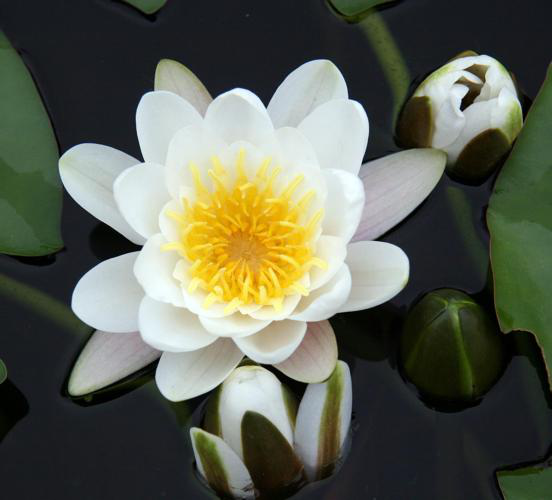

In [4]:
dataset[400]['image']

In [5]:
id2label[dataset[400]['label']]

'water lily'

### Data Preprocessing

In [6]:
model_checkpoint = 'microsoft/resnet-101'

In [7]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [8]:
import torchvision.transforms as transforms

image_length = image_processor.size['shortest_edge']
image_dims = (image_length, image_length)
normalizer = transforms.Normalize(
    mean=image_processor.image_mean,
    std=image_processor.image_std
)

transformations = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_dims),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalizer
    ]),
    'validation': transforms.Compose([
        transforms.Resize(image_dims),
        transforms.CenterCrop(image_dims),
        transforms.ToTensor(),
        normalizer
    ]),
    'test': transforms.Compose([
        transforms.Resize(image_dims),
        transforms.CenterCrop(image_dims),
        transforms.ToTensor(),
        normalizer
    ]),
}

def preprocess(transformation):
    def preprocessT(batch):
        batch['pixel_values'] = [ transformation(image.convert('RGB')) for image in batch['image'] ]
        return batch
    return preprocessT

/home/harsh/miniconda3/envs/deep-learning/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/harsh/miniconda3/envs/deep-learning/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [9]:
# creating a 70%-15%-15% train-val-test split

splits = dataset.train_test_split(train_size=0.7)
train_ds = splits['train']
splits = splits['test'].train_test_split(test_size=0.5)
val_ds = splits['train']
test_ds = splits['test']

train_ds.set_transform(preprocess(transformations['train']))
val_ds.set_transform(preprocess(transformations['validation']))
test_ds.set_transform(preprocess(transformations['test']))

In [10]:
val_ds[0:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=700x500>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=752x500>],
 'label': [62, 45],
 'pixel_values': [tensor([[[-1.3644, -1.1932, -1.0733,  ...,  0.3481,  0.3309,  0.3481],
           [-1.3473, -1.1760, -1.1075,  ...,  0.3138,  0.2967,  0.3138],
           [-1.3302, -1.1589, -1.1418,  ...,  0.2453,  0.2453,  0.2453],
           ...,
           [-0.6623, -0.5938, -0.2171,  ..., -0.8335, -0.8335, -0.8335],
           [-0.7650, -0.5938, -0.3883,  ..., -0.7993, -0.7993, -0.7993],
           [-0.6452, -0.5253, -0.5082,  ..., -0.8335, -0.8335, -0.8164]],
  
          [[-1.2304, -1.0378, -0.8978,  ...,  0.2402,  0.2227,  0.2402],
           [-1.2129, -1.0203, -0.9328,  ...,  0.2052,  0.1877,  0.2052],
           [-1.1604, -0.9853, -0.9678,  ...,  0.1352,  0.1352,  0.1352],
           ...,
           [-0.7577, -0.7052, -0.3200,  ..., -0.4776, -0.4776, -0.4951],
           [-0.8277, -0.6176, -0.3550,  ..., -0.5301, 

### Configure Model

In [11]:
from transformers import ResNetForImageClassification, Trainer, TrainingArguments

model = ResNetForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)
model

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-101 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([102, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [12]:
model_name = model_checkpoint.split('/')[-1]

batch_size = 32

trainArgs = TrainingArguments(
    learning_rate=1e-3,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    warmup_ratio=0.1,
    remove_unused_columns=False, # VERY IMPORTANT! Especially if you are doing batched preprocessing on-the-fly!
    evaluation_strategy='epoch',
    metric_for_best_model='accuracy',
    load_best_model_at_end=True,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_strategy='epoch',
    output_dir=f'models/{model_name}-finetuned-flowers102',
    logging_steps=0.1,
)

In [13]:
import numpy as np
import evaluate
import torch

metric = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    preds = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=preds, references=eval_pred.label_ids)

def collate_fn(batch):
    pixel_values = torch.stack([ sample['pixel_values'] for sample in batch ])
    labels = torch.tensor([ sample['label'] for sample in batch ])
    return {'pixel_values': pixel_values, 'labels': labels}

In [14]:
trainer = Trainer(
    model,
    trainArgs,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

### Train and Evaluate Model

In [15]:
# obtain baseline
test_metrics = trainer.evaluate(test_ds, metric_key_prefix='test')
trainer.log_metrics('test', test_metrics)

***** test metrics *****
  test_accuracy           =     0.0114
  test_loss               =      4.626
  test_runtime            = 0:00:20.73
  test_samples_per_second =     59.285
  test_steps_per_second   =      1.881


In [16]:
# obtain validation scores for 0th epoch
eval_metrics = trainer.evaluate()
trainer.log_metrics('eval', eval_metrics)

***** eval metrics *****
  eval_accuracy           =     0.0081
  eval_loss               =     4.6274
  eval_runtime            = 0:00:20.32
  eval_samples_per_second =     60.426
  eval_steps_per_second   =      1.919


In [17]:
# train model
train_results = trainer.train()
train_results

Epoch,Training Loss,Validation Loss,Accuracy
1,3.724800,3.016033,0.347720
2,1.378300,0.880130,0.770358
3,0.758400,0.559654,0.860749


TrainOutput(global_step=135, training_loss=2.2870859711258498, metrics={'train_runtime': 6218.5767, 'train_samples_per_second': 2.765, 'train_steps_per_second': 0.022, 'total_flos': 6.633106765965066e+17, 'train_loss': 2.2870859711258498, 'epoch': 3.0})

In [18]:
trainer.log_metrics('train', train_results.metrics)

***** train metrics *****
  epoch                    =         3.0
  total_flos               = 617756207GF
  train_loss               =      2.2871
  train_runtime            =  1:43:38.57
  train_samples_per_second =       2.765
  train_steps_per_second   =       0.022


In [20]:
trainer.save_model()
trainer.save_metrics("test0", test_metrics)
trainer.save_metrics("train", train_results.metrics)

In [21]:
test_metrics = trainer.evaluate(test_ds, metric_key_prefix='test')
trainer.log_metrics('test', test_metrics)
trainer.save_metrics('test1', trest_metrics)

***** test metrics *****
  epoch                   =        3.0
  test_accuracy           =     0.8723
  test_loss               =     0.5358
  test_runtime            = 0:00:35.78
  test_samples_per_second =     34.341
  test_steps_per_second   =       1.09


NameError: name 'trest_metrics' is not defined

In [22]:
trainer.save_metrics('test1', test_metrics)

### Inference

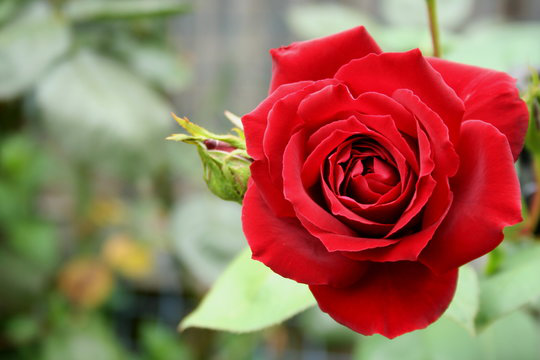

In [43]:
from PIL import Image
import requests

url = 'https://t4.ftcdn.net/jpg/02/41/36/69/360_F_241366907_wK6lDuOcbyXLtbj8HsngXpnIHx0xd9JQ.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [44]:
from transformers import AutoModelForImageClassification, AutoImageProcessor
trained_model = AutoModelForImageClassification.from_pretrained('./models/resnet-101-finetuned-flowers102/')
image_processor = AutoImageProcessor.from_pretrained('microsoft/resnet-101')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [47]:
from transformers import pipeline

pipe = pipeline('image-classification', model=trained_model, image_processor=image_processor)
pipe

In [48]:
pipe(image)

[{'score': 0.9551404714584351, 'label': 'rose'},
 {'score': 0.016405411064624786, 'label': 'artichoke'},
 {'score': 0.0074507142417132854, 'label': 'foxglove'},
 {'score': 0.0036506152246147394, 'label': 'bird of paradise'},
 {'score': 0.0026995830703526735, 'label': 'corn poppy'}]